# Model 6: Vertical and horizontal cultural transmission

### Note

- One obvious difference between cultural and genetic evolution is in their pathways of transmission.
    - In genetic evolution, we get our genes exclusively from our two biological parents.
    - In cultural evolution, we get cultural traits from a wide array of sources.
- Model 1 〜 5 are oblique cultural transmission.
- In Model 6 we will consider
    - vertical cultural transmission, in which agents learn from two parents, and
    - horizontal cultural transmission, where agents learn from members of the same generation.

Whole structure

- Transmission
    - Oblique
        - Unbiased (Model 1)
        - Biased
            - Direct / content bias (Model 3): 直接 Trait が伝播しやすさに紐付いている。
            - Indirect bias (Model 4): Trait 以外の属性 (ペイオフ、年齢、ジェンダー、社会階層 など) が、伝播しやすさに紐付いている。
            - Conformist bias (Model 5): 多数派のTraitを真似する。
    - Vertical and Horizontal (Model 6)
- Mutation (Model 2)
    - Unbiased
    - Biased

## Model 6a: Vertical cultural transmission

In [1]:
using DataFrames
using Random
using Statistics
using Plots
gr();

In [2]:
@enum Trait A B

# same as model 1
function make_agents_df(N::Int64, p_0::Float64)::DataFrame
    traits = [rand() < p_0 ? A : B for _ in 1:N]
    return DataFrame(trait = traits)
end

# same as model 1
function make_outputs_df(r_max::Int64, t_max::Int64)::DataFrame
    # r: trial number
    # t: generation number
    # p: proportion of individuals who possess trait A
    return DataFrame(
        r = fill(0, r_max * t_max),
        t = fill(0, r_max * t_max),
        p = fill(-1.0, r_max * t_max)
    )
end

# same as model 1
function calc_p(_agents_df::DataFrame)::Float64
    return nrow(_agents_df[_agents_df.trait.==A, :]) / nrow(_agents_df)
end

# same as model 1
function plot_outputs_df(outputs_df::DataFrame, title::String)::Plots.Plot
    p = plot(
        outputs_df[outputs_df.r.== 1, :].p,
        ylims = (-0.01, 1.01),
        title = title,
        xlabel = "generation",
        ylabel = "p, proportion of agents with trait A",
        legend = false
    )
    for r = 2:maximum(outputs_df.r)
        plot!(outputs_df[outputs_df.r.== r, :].p)
    end
    
    mean_df = combine(groupby(outputs_df, :t), :p => mean)
    plot!(mean_df.p_mean, lw = 4, lc = :black)

    return p
end

# modified based on model 5
function get_new_trait(father::Trait, mother::Trait, s_v::Float64)::Trait
    # 次のTraitがAになる確率
    prob = if father == A && mother == A
        1.0
    elseif (father == A && mother == B) || (father == B && mother == A)
        1 / 2 + s_v / 2
    elseif father == B && mother == B
        0.0
    end

    return prob > rand() ? A : B
end

# modified based on model 5
function vertical_transmission(N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, s_v::Float64)::DataFrame
    outputs_df = make_outputs_df(r_max, t_max)

    for r = 1:r_max
        agents_df = make_agents_df(N, p_0)

        for t = 1:t_max
            if t > 1
                fathers = shuffle(agents_df.trait)
                mothers = shuffle(agents_df.trait)
                agents_df = DataFrame(trait = [get_new_trait(father, mother, s_v) for (father, mother) in zip(fathers, mothers)])
            end

            # get p and put it into the output slot for this generation t
            row_num = t + (r - 1) * t_max
            outputs_df.r[row_num] = r
            outputs_df.t[row_num] = t
            outputs_df.p[row_num] = calc_p(agents_df)
        end
    end
    
    return outputs_df
end

# modified based on model 5
function run(; N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, s_v::Float64)
    outputs_df = vertical_transmission(N, r_max, t_max, p_0, s_v)
    plot_outputs_df(outputs_df, "N = $N, p_0 = $p_0, s_v = $s_v")
end;

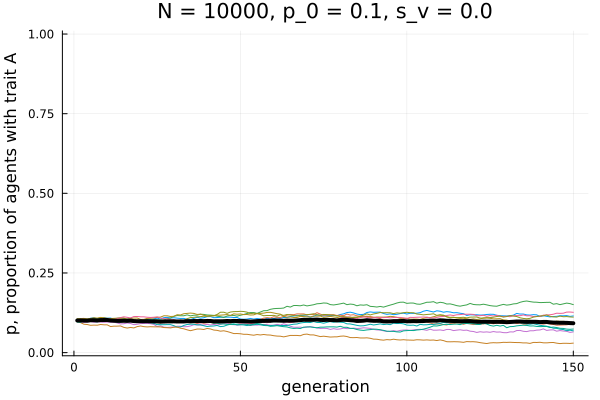

In [3]:
run(N = 10^4, r_max = 10, t_max = 150, p_0 = 0.1, s_v = 0.0)

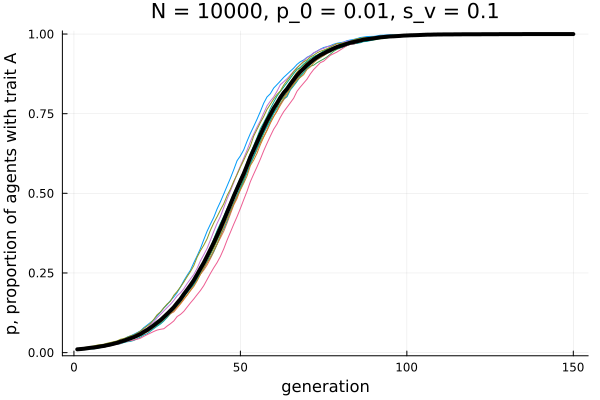

In [4]:
run(N = 10^4, r_max = 10, t_max = 150, p_0 = 0.01, s_v = 0.1)

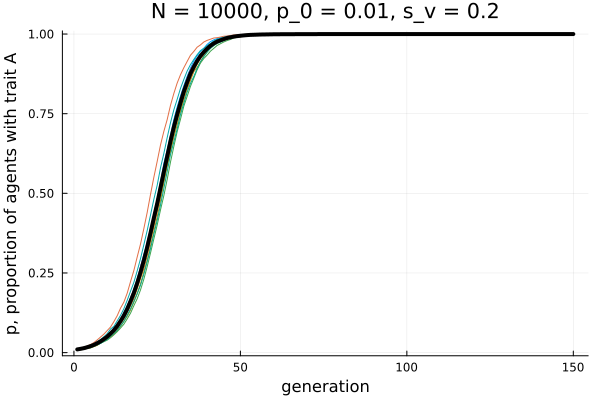

In [5]:
run(N = 10^4, r_max = 10, t_max = 150, p_0 = 0.01, s_v = 0.2)

### Note

- 結果は、[Model 3: Biased transmission (direct / content bias)](https://github.com/mas178/social-simulation/blob/main/Mesoudi2021/model03_biased_transmission_direct_content_bias.ipynb) によく似ている。
- Model 3 が1人の親からTraitを受け継ぐのに対して、Model 6 は2人の親からTraitを受け継いでいると見做せる。

## Model 6b: Assortative mating (同類交配)

### Note

- In reality, parents may be more culturally similar than average.
- In evolutionary biology, this is known as **assortative mating (同類交配)**.

In [6]:
function vertical_transmission(N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, s_v::Float64, a::Float64)::DataFrame
    outputs_df = make_outputs_df(r_max, t_max)

    for r = 1:r_max
        agents_df = make_agents_df(N, p_0)

        for t = 1:t_max
            if t > 1
                mothers = shuffle(agents_df.trait)
                fathers = [a > rand() ? mother : rand(agents_df.trait) for mother in mothers]
                agents_df = DataFrame(trait = [get_new_trait(father, mother, s_v) for (father, mother) in zip(fathers, mothers)])
            end

            # get p and put it into the output slot for this generation t
            row_num = t + (r - 1) * t_max
            outputs_df.r[row_num] = r
            outputs_df.t[row_num] = t
            outputs_df.p[row_num] = calc_p(agents_df)
        end
    end
    
    return outputs_df
end

# modified based on model 5
function run(; N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, s_v::Float64, a::Float64)
    outputs_df = vertical_transmission(N, r_max, t_max, p_0, s_v, a)
    plot_outputs_df(outputs_df, "N = $N, p_0 = $p_0, s_v = $s_v, a = $a")
end;

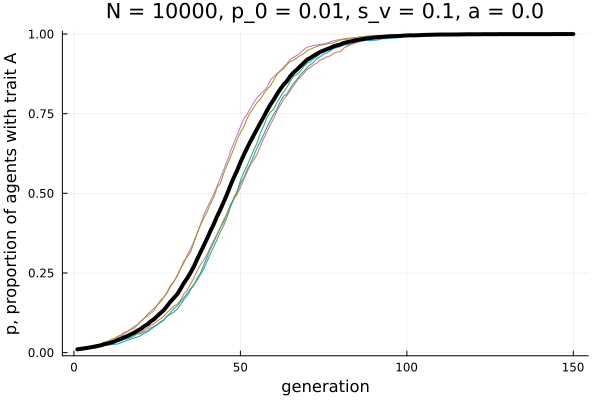

In [7]:
run(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = 0.1, a = 0.0)

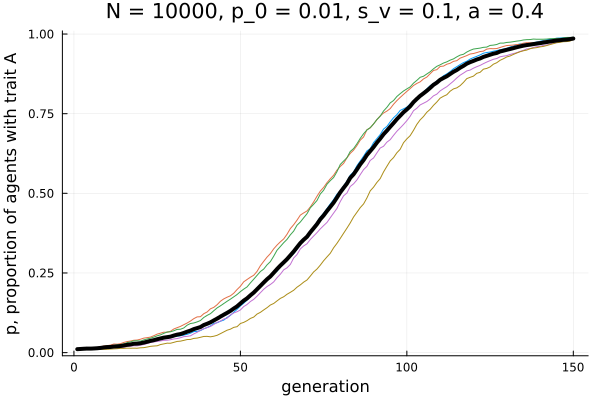

In [8]:
run(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = 0.1, a = 0.4)

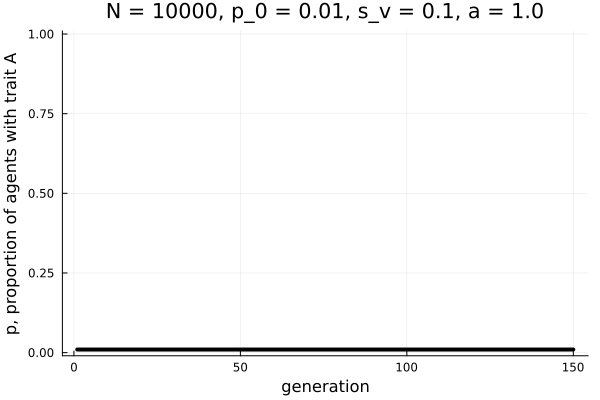

In [9]:
run(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = 0.1, a = 1.0)

### Note

- Complete assortative mating results in no cultural change, beyond random fluctuations, even when selection is acting.
- In general, the more assortative mating there is, the weaker cultural selection will be.

## Model 6c: Horizontal cultural transmission

### Note

- There are many ways of implementing horizontal cultural transmission.
- To allow a comparison with vertical transmission, here we will assume directly biased horizontal transmission.
- In Model 6c we assume that agents now choose $n$ members of the same generation, i.e. the set of agents who have already undergone vertical transmission.
- If at least one of those $n$ demonstrators has trait $A$, then the learner adopts trait $A$ with probability $s_h$.

In [10]:
function vertical_horizontal_transmission(N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, s_v::Float64, s_h::Float64, a::Float64, n::Int64)::DataFrame
    outputs_df = make_outputs_df(r_max, t_max)

    for r = 1:r_max
        agents_df = make_agents_df(N, p_0)

        for t = 1:t_max
            if t > 1
                # 1. assortative mating:
                mothers = shuffle(agents_df.trait)
                fathers = [a > rand() ? mother : rand(agents_df.trait) for mother in mothers]
                
                # 2. vertical transmission:
                agents_df = DataFrame(trait = [get_new_trait(father, mother, s_v) for (father, mother) in zip(fathers, mothers)])
                
                # 3. horizontal transmission:
                demonstrators = rand(agents_df.trait, (N, n))
                oneA = [count(d .== A) >= 1 for d in eachrow(demonstrators)]
                agents_df.trait = [(one_a && s_h > rand()) ? A : t for (t, one_a) in zip(agents_df.trait, oneA)]
            end

            # get p and put it into the output slot for this generation t
            row_num = t + (r - 1) * t_max
            outputs_df.r[row_num] = r
            outputs_df.t[row_num] = t
            outputs_df.p[row_num] = calc_p(agents_df)
        end
    end
    
    return outputs_df
end

# modified based on model 5
function run(; N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, s_v::Float64, s_h::Float64, a::Float64, n::Int64)
    outputs_df = vertical_horizontal_transmission(N, r_max, t_max, p_0, s_v, s_h, a, n)
    plot_outputs_df(outputs_df, "N = $N, p_0 = $p_0, s_v = $s_v, s_h = $s_h, a = $a, n = $n")
end;

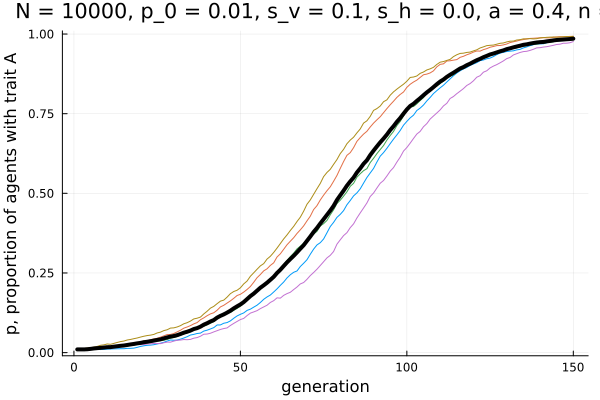

In [11]:
run(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = 0.1, s_h = 0.0, a = 0.4, n = 0)

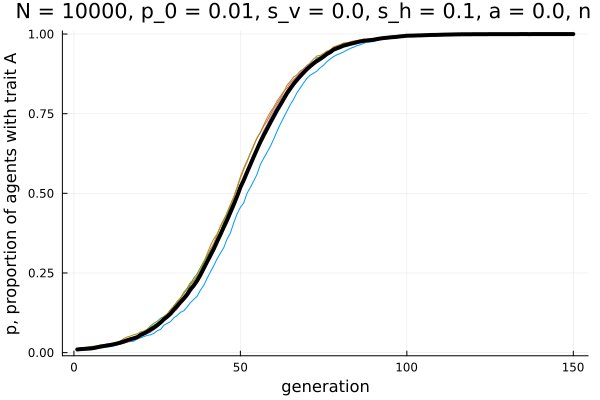

In [12]:
run(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = 0.0, s_h = 0.1, a = 0.0, n = 1)

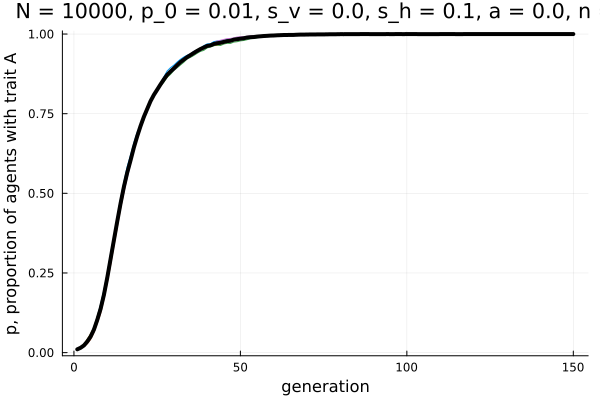

In [13]:
run(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = 0.0, s_h = 0.1, a = 0.0, n = 5)

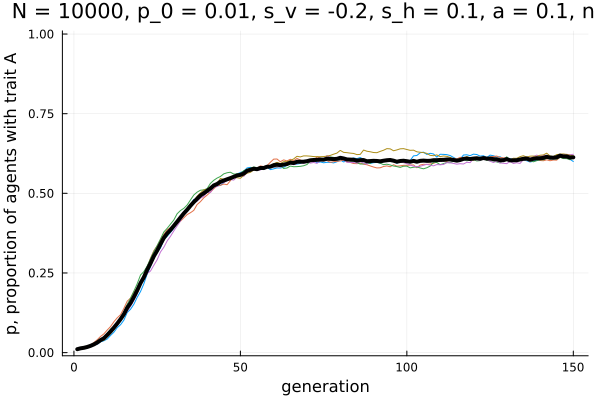

In [14]:
run(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s_v = -0.2, s_h = 0.1, a = 0.1, n = 5)